In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import h5py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA ACQUISITION

In [ ]:
import os
from pathlib import Path
folder_path_train = '/content/drive/My Drive/SRCNN/Models'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_train = '/content/drive/My Drive/SRCNN/Train_Set'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_lr = '/content/drive/My Drive/SRCNN/Train_Set/Train_LR'
Path(folder_path_lr).mkdir(parents=True, exist_ok=True)

folder_path_hr = '/content/drive/My Drive/SRCNN/Train_Set/Train_HR'
Path(folder_path_hr).mkdir(parents=True, exist_ok=True)

# STATE OF THE ART MODEL

In [ ]:
# Simple Baseline SRCNN model
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 128, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(64, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# DATA ACQUISITION AND PROCESSING

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Replace 'yourfile.h5' with the path to your H5 file
with h5py.File('/content/drive/MyDrive/SRCNN/91-image_x2.h5', 'r') as f:
    # Assuming 'image_data' is the key in your H5 file that contains images
    images = np.array(f['lr'])
    # Display the first image as an example
    print(images.shape[2])
    plt.imshow(images[1500])
    plt.show()

# MODEL TRAINING AND FINE TUNING

In [ ]:
from tqdm import tqdm
model = SRCNN()
epochs = 10
batch_size = 10
lr = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.conv3.parameters(), 'lr': lr * 0.1}
], lr=lr)

train_dataset = TrainDataset('/content/drive/MyDrive/SRCNN/91-image_x2.h5')
train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=10,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)


for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for lr_images, hr_images in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
    # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(lr_images)

      # Compute loss
      loss = criterion(outputs, hr_images)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

# Print epoch statistics
print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_h5.pth')

In [ ]:
model = SRCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_h5.pth'))

<All keys matched successfully>

In [ ]:
import numpy as np
import PIL.Image as pil_image
def convert_rgb_to_ycbcr(img):
  if type(img) == np.ndarray:
      y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
      cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
      cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
      return np.array([y, cb, cr]).transpose([1, 2, 0])
  elif type(img) == torch.Tensor:
      if len(img.shape) == 4:
          img = img.squeeze(0)
      y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
      cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
      cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
      return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
  else:
      raise Exception('Unknown Type', type(img))

def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))

# MODEL EVALUATION

In [ ]:
model.eval()
scale = 2
image_file = '/content/drive/MyDrive/SRCNN/Test_Set/Test_HR/butterfly_GT.bmp'
hr_image_cv = cv2.imread(image_file)
# image_file = '/content/drive/MyDrive/SRCNN/Train/Copy of t1.bmp'
# hr_image_cv = cv2.imread(image_file)
print(hr_image_cv.shape)
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float32')/255.0
image = pil_image.open(image_file).convert('RGB')

image_width = (image.width // scale) * scale
image_height = (image.height // scale) * scale
image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
image.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))

image = np.array(image).astype(np.float32)
imagepsnr = image/255.0
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
y = y.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y).clamp(0.0, 1.0)

(400, 400, 3)


In [ ]:
print(preds.shape)
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
# output = output.astype('float32')/255.0
# print(output)
# print(output.shape)
output = pil_image.fromarray(output)
output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

In [ ]:
# output = pil_image.fromarray(output)
# output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
# print(output.shape)
# print(image.shape)

hr_image_cv = cv2.imread('/content/drive/MyDrive/SRCNN/Test_Set/Test_HR/butterfly_GT.bmp')
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float32')/255.0

generated_image_cv = cv2.imread('/content/drive/MyDrive/SRCNN/Test_Set/Test_HR/butterfly_GT_srcnn_x2.bmp')
generated_image_rgb = cv2.cvtColor(generated_image_cv, cv2.COLOR_BGR2RGB)
generated_image_rgb = generated_image_rgb.astype('float32')/255.0

lr_image_cv = cv2.imread('/content/drive/MyDrive/SRCNN/Test_Set/Test_HR/butterfly_GT_bicubic_x2.bmp')
lr_image_rgb = cv2.cvtColor(lr_image_cv, cv2.COLOR_BGR2RGB)
lr_image_rgb = lr_image_rgb.astype('float32')/255.0
print("Signal to noise ratio between generated image and HR image: " + str(psnr(hr_image_rgb, generated_image_rgb)))
print("Signal to noise ratio between LR image and HR image: " +str(psnr(hr_image_rgb, lr_image_rgb)))

Signal to noise ratio between generated image and HR image: 36.95332846126478
Signal to noise ratio between LR image and HR image: 34.80907039823584


# INFERENCE, OPTIMIZATION AND REAL TIME TEST

In [ ]:
class EvalDataset(torch.utils.data.Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0), np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
from tqdm import tqdm

eval_dataset = EvalDataset('/content/drive/MyDrive/SRCNN/Set5_x2.h5')
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

In [ ]:
model.eval()

# Criterion for loss
criterion = nn.MSELoss()

# Accumulators
running_loss = 0.0
psnr_score_loss = 0
total_images = 0

with torch.no_grad():  # Deactivate autograd for evaluation
    for inputs, labels in tqdm(eval_dataloader, desc='Evaluating', leave=False):
        # Forward pass: compute the model's predictions for the inputs
        preds = model(inputs).clamp(0.0, 1.0)

        loss = criterion(preds, labels)
        running_loss += loss.item()

        pred_i = preds.squeeze()
        label_i = labels.squeeze()
        input_i = inputs.squeeze()

        # Convert to numpy arrays
        pred_np = pred_i.cpu().numpy()
        label_np = label_i.cpu().numpy()
        input_np = input_i.cpu().numpy()

        # Calculate PSNR for generated and original LR images
        psnr_score_hr_gen = psnr(pred_np, label_np)
        psnr_score_hr_lr = psnr(input_np, label_np)
        psnr_score_loss += psnr_score_hr_gen - psnr_score_hr_lr
        total_images += 1

average_loss = running_loss / total_images
average_psnr_diff = psnr_score_loss / total_images

print(f'Test Loss: {average_loss:.6f}')
print(f'Average PSNR Difference: {average_psnr_diff:.6f}')

Test Loss: 0.000320
Average PSNR Difference: 2.265633


In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
model = SRCNN()
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
traced_model = torch.jit.script(model, input_tensor)
traced_model.save("/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_script_h5.pt")

torch.Size([1, 1, 400, 400])


/usr/local/lib/python3.10/dist-packages/torch/jit/_script.py:1291: UserWarning: `optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead
  warnings.warn(


In [ ]:
import time
model  = SRCNN()
loaded_model = torch.jit.load("/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_script_h5.pt")
model.load_state_dict(torch.load('/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_h5.pth'))
loaded_model.load_state_dict(model.state_dict())
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
overall = 0
for i in range(50):
  start_time = time.time()

  with torch.no_grad():
      output = loaded_model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

torch.Size([1, 1, 400, 400])
1.637077684402466


In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
model  = SRCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/SRCNN/Models/SRCNN_weights_h5.pth'))
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
overall = 0
for i in range(50):
  start_time = time.time()

  with torch.no_grad():
      output = model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

torch.Size([1, 1, 400, 400])
1.812661566734314


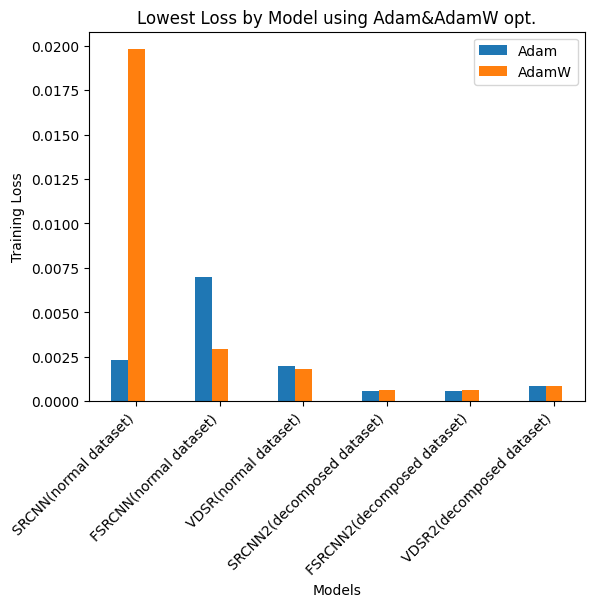

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['SRCNN(normal dataset)', 'FSRCNN(normal dataset)', 'VDSR(normal dataset)', 'SRCNN2(decomposed dataset)', 'FSRCNN2(decomposed dataset)', 'VDSR2(decomposed dataset)']
regions = ['Adam', 'AdamW']
data = np.array([
    [0.0023, 0.0198],
    [0.007, 0.00296],
    [0.0020, 0.0018],
    [0.00058,0.00061],
    [0.000588, 0.000646],
    [0.00088,0.00088]
])

x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    ax.bar(x + i * width, data[:, i], width, label=region)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Training Loss')
ax.set_title('Lowest Loss by Model using Adam&AdamW opt.')
ax.set_xticks(x + width)
ax.set_xticklabels(categories, rotation=45, ha="right")
# ax.set_xticklabels(categories)
ax.legend()
plt.show()

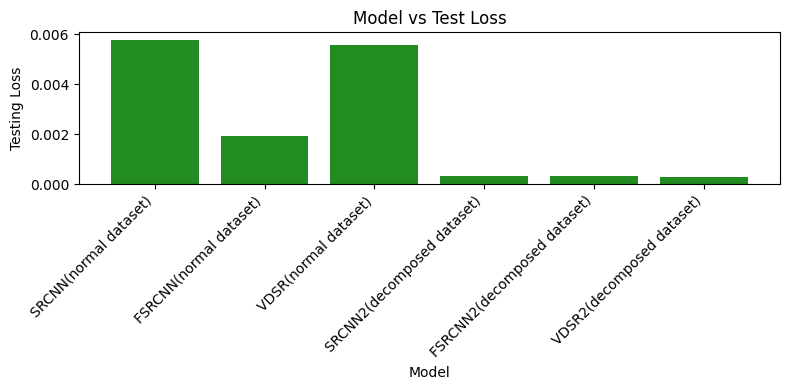

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
x = ['SRCNN(normal dataset)', 'FSRCNN(normal dataset)', 'VDSR(normal dataset)', 'SRCNN2(decomposed dataset)', 'FSRCNN2(decomposed dataset)', 'VDSR2(decomposed dataset)']
y = [0.00578, 0.001939, 0.00556, 0.00032, 0.000311, 0.000285]  # Y-axis values corresponding to each x-axis point

plt.figure(figsize=(8, 4))  # Set the figure size
plt.bar(x, y, color='forestgreen')  # Create a bar plot

plt.xlabel('Model')  # Label for X-axis
plt.ylabel('Testing Loss')  # Label for Y-axis
plt.title('Model vs Test Loss')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


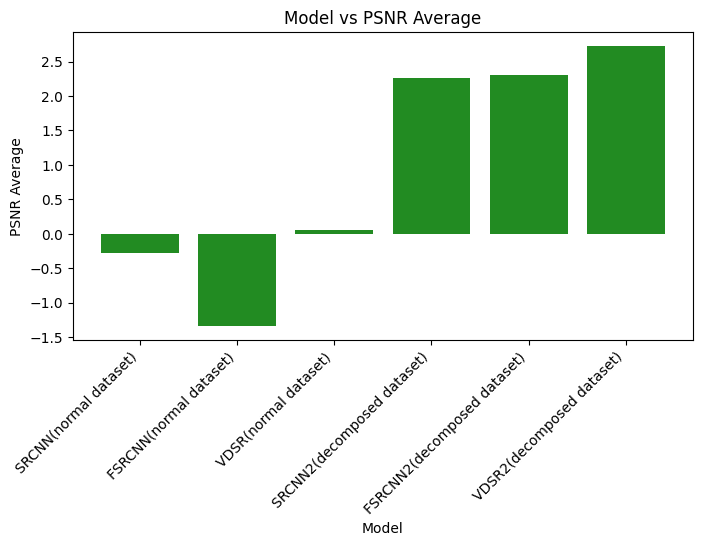

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
x = ['SRCNN(normal dataset)', 'FSRCNN(normal dataset)', 'VDSR(normal dataset)', 'SRCNN2(decomposed dataset)', 'FSRCNN2(decomposed dataset)', 'VDSR2(decomposed dataset)']
y = [-0.2789, -1.3386, 0.05437, 2.265633, 2.303270, 2.722168]  # Y-axis values corresponding to each x-axis point

plt.figure(figsize=(8, 4))  # Set the figure size
plt.bar(x, y, color='forestgreen')  # Create a bar plot

plt.xlabel('Model')  # Label for X-axis
plt.ylabel('PSNR Average')  # Label for Y-axis
plt.title('Model vs PSNR Average')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels

plt.show()
